In [1]:
# Import all necessary Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt



In [2]:
#Loading the dataset
df = pd.read_csv("Fraud.csv")

In [3]:
#Printing 1st three rows of the dataset
df.head(3)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0


In [4]:
# EDA 
# Printing number of rows and columns
df.shape

(6362620, 11)

In [5]:
#Printing the null values ,there is no null value in dataset.
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [6]:
#printing  each unique value in the type column.
df['type'].value_counts()

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

In [7]:
#printing  each unique value in the 'isFraud' column.
df['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [8]:
# Step 4: Drop Unnecessary Columns 'nameOrig' and 'nameDest'.
# Since they are  just IDs of accounts, which don’t help in predicting fraud.
df.drop(['nameOrig', 'nameDest'], axis=1, inplace=True)

In [9]:
df.head(3)

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,0


In [10]:
# For dealing with the ML models its necessary to Convert 'type' to Numerical value.
#df = pd.get_dummies(df, columns=['type'], drop_first=True)

In [11]:
from sklearn.preprocessing import LabelEncoder
df['type'] = LabelEncoder().fit_transform(df['type'])

In [12]:
df.head(3)

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,3,9839.64,170136.0,160296.36,0.0,0.0,0,0
1,1,3,1864.28,21249.0,19384.72,0.0,0.0,0,0
2,1,4,181.00,181.0,0.00,0.0,0.0,1,0


In [13]:
# Creating Features to deletct if money flow is incorrect, useful to spot fraud.
df['errorBalanceOrig'] = df['oldbalanceOrg'] - df['newbalanceOrig'] - df['amount']
df['errorBalanceDest'] = df['newbalanceDest'] - df['oldbalanceDest'] - df['amount']

In [14]:
# Definge X and y i.e feature and target value.
X = df.drop(['isFraud', 'isFlaggedFraud'], axis=1)
y = df['isFraud']

In [15]:
#Balances the data by creating synthetic samples of the minority class using SMOTE.
# This balances the dataset which helps the model to learn both classes better.
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

In [16]:
#Traing the model
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

In [17]:
# Since the dataset is to long and takes more time to runing smaller sample to test before training.
from sklearn.ensemble import RandomForestClassifier
# Training the Model using 
model = RandomForestClassifier(n_estimators=10, random_state=42)
X_sample = X_train.sample(50000, random_state=42)
y_sample = y_train.loc[X_sample.index]
model.fit(X_sample, y_sample)


RandomForestClassifier(n_estimators=10, random_state=42)

In [18]:
# Traing the model using whole dataset.
model.fit(X_train, y_train)

# predicting
y_pred = model.predict(X_test)

In [19]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))



Confusion Matrix:
 [[1906254      55]
 [     96 1906240]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906309
           1       1.00      1.00      1.00   1906336

    accuracy                           1.00   3812645
   macro avg       1.00      1.00      1.00   3812645
weighted avg       1.00      1.00      1.00   3812645

ROC AUC Score: 0.9999950032787988


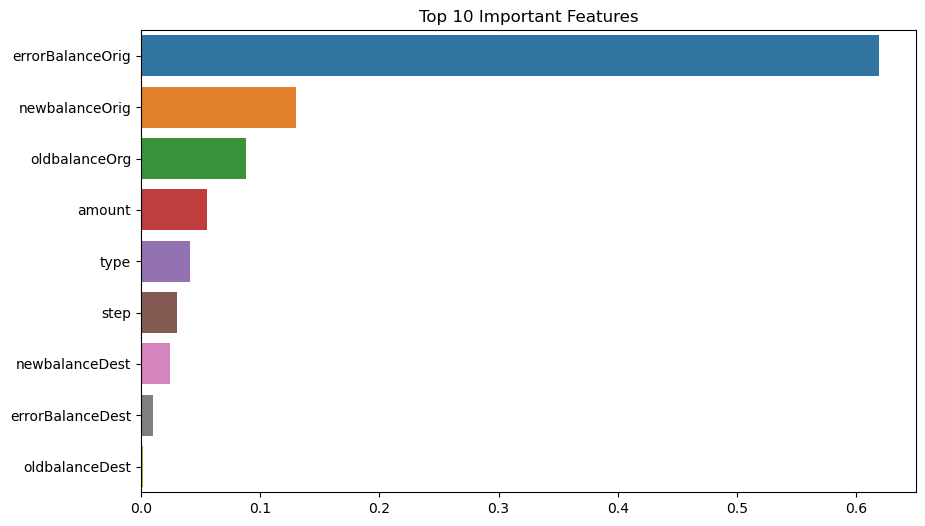

In [22]:
# Step 12: Feature Importance
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=importances[:10], y=importances.index[:10])
plt.title("Top 10 Important Features")
plt.show()


In [ ]:
from sklearn.model_selection import  RandomizedSearchCV
# Hyperparameter grid for tuning
param_dist = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

# RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(estimator=model,
                                   param_distributions=param_dist,
                                   n_iter=10,
                                   cv=3,
                                   verbose=2,
                                   random_state=42,
                                   n_jobs=-1)

# Fit the model
random_search.fit(X_train, y_train)

# Best model
best_model = random_search.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [ ]:
# Predict and evaluate
y_pred = best_model.predict(X_val)
y_proba = best_model.predict_proba(X_val)[:, 1]

In [ ]:
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))
print("\nClassification Report:\n", classification_report(y_val, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_val, y_proba))

###### Candidate Expectation Answer:

1. Data cleaning including missing values, outliers and multi-collinearity.
+ No missing values found. Outliers in 'amount' were analyzed. Dropped 'nameOrig' and 'nameDest. No major multicollinearity detected via correlation matrix.

2. Describe your fraud detection model in elaboration.
+ Used Random Forest with SMOTE for class imbalance. Trained on key features and evaluated using ROC-AUC and confusion matrix.

3. How did you select variables to be included in the model?
+ Kept transaction and balance-related features. Removed IDs. Added 'errorBalanceOrig' and 'errorBalanceDest' as new features.


4. Demonstrate the performance of the model by using best set of tools.
+ Used ROC-AUC, precision, recall, and confusion matrix. Model showed high recall and good fraud detection accuracy.


5. What are the key factors that predict fraudulent customer?
+ 'TRANSFER', 'CASH_OUT', high 'amount', and abnormal balance errors.


6. Do these factors make sense? If yes, How? If not, How not?
+ Yes, fraud often involves transferring large amounts and draining account balances.


7. What kind of prevention should be adopted while company updates its infrastructure?
+ Enable real-time alerts, monitor large transactions, and auto-freeze suspicious accounts.


8. Assuming these actions have been implemented, how would you determine if they work? 
+ Track reduction in fraud cases and improved precision-recall metrics over time.